# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Combining Datasets

In [3]:
msn10 = pd.read_csv("data/msn_10_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn11 = pd.read_csv("data/msn_11_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn12 = pd.read_csv("data/msn_12_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn14 = pd.read_csv("data/msn_14_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn29 = pd.read_csv("data/msn_29_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn37 = pd.read_csv("data/msn_37_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn53 = pd.read_csv("data/msn_53_fuel_leak_signals_preprocessed.csv", delimiter=';')

In [4]:
combined = pd.concat([msn10, msn11, msn12, msn14, msn29, msn37, msn53])

In [5]:
# Only Flight Phase Cruise
combined = combined[combined["FLIGHT_PHASE_COUNT"]==8.0]

In [6]:
# Setting index as datetime
combined['UTC_TIME'] = pd.to_datetime(combined['UTC_TIME'])
combined = combined.set_index("UTC_TIME")

In [7]:
# Dropping Duplicates
combined = combined.drop_duplicates()

In [8]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17821133 entries, 2014-07-25 12:44:49 to 2018-04-22 16:29:23
Data columns (total 16 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   FUEL_USED_2         377742 non-null    float64
 1   FUEL_USED_3         377333 non-null    float64
 2   FUEL_USED_4         378210 non-null    float64
 3   FW_GEO_ALTITUDE     17821133 non-null  float64
 4   VALUE_FOB           17821133 non-null  float64
 5   VALUE_FUEL_QTY_CT   17821133 non-null  float64
 6   VALUE_FUEL_QTY_FT1  17821133 non-null  float64
 7   VALUE_FUEL_QTY_FT2  17821133 non-null  float64
 8   VALUE_FUEL_QTY_FT3  17821133 non-null  float64
 9   VALUE_FUEL_QTY_FT4  17821133 non-null  float64
 10  VALUE_FUEL_QTY_LXT  17821133 non-null  float64
 11  VALUE_FUEL_QTY_RXT  17821133 non-null  float64
 12  FLIGHT_PHASE_COUNT  17821133 non-null  float64
 13  FUEL_USED_1         378494 non-null    float64
 14  Flight          

In [9]:
# Drop null columns
fuel_columns = ["FUEL_USED_1", "FUEL_USED_2", "FUEL_USED_3", "FUEL_USED_4"]
combined = combined.dropna(subset=fuel_columns)

In [10]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376554 entries, 2015-07-21 03:51:31 to 2018-04-22 11:45:45
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FUEL_USED_2         376554 non-null  float64
 1   FUEL_USED_3         376554 non-null  float64
 2   FUEL_USED_4         376554 non-null  float64
 3   FW_GEO_ALTITUDE     376554 non-null  float64
 4   VALUE_FOB           376554 non-null  float64
 5   VALUE_FUEL_QTY_CT   376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1  376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2  376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3  376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4  376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT  376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT  376554 non-null  float64
 12  FLIGHT_PHASE_COUNT  376554 non-null  float64
 13  FUEL_USED_1         376554 non-null  float64
 14  Flight              376554 non-null  float64
 15  

# Feature Engineering

**THINGS TO CONSIDER**

| **Column Name** | **Description** |
| ----------- | ----------- |
| `VALUE_FOB` | Fuel on Board |
| `VALUE_FUEL_QTY_CT` | Central Tank |
| `VALUE_FUEL_QTY_FT1` | Fuel Quantity Feed Tank 1 (Engine 1) |
| `VALUE_FUEL_QTY_FT2` | Fuel Quantity Feed Tank 2 (Engine 2) |
| `VALUE_FUEL_QTY_FT3` | Fuel Quantity Feed Tank 3 (Engine 3) |
| `VALUE_FUEL_QTY_FT4` | Fuel Quantity Feed Tank 1 (Engine 4) |
| `VALUE_FUEL_QTY_LXT` | Fuel Quantity Transfer Tank Left |
| `VALUE_FUEL_QTY_RXT` | Fuel Quantity Transfer Tank Right |
| `FUEL_USED_1` | Fuel Used (Engine 1) |
| `FUEL_USED_2` | Fuel Used (Engine 2) |
| `FUEL_USED_3` | Fuel Used (Engine 3) |
| `FUEL_USED_4` | Fuel Used (Engine 4) |

Based on typical Airbus engining, we ca thus assume the following:

| **Column Name** | **Left vs Right Side**|
| ----------- | ----------- |
| `VALUE_FUEL_QTY_LXT` | Left Outer fuel Quantity |
| `VALUE_FUEL_QTY_FT1` | Left Inner Fuel Quanitity  |
| `VALUE_FUEL_QTY_FT2` | Left Inner Fuel Quantity |
| `VALUE_FUEL_QTY_RXT` | Right Outer Fuel Quantity |
| `VALUE_FUEL_QTY_FT3` | Right Inner Fuel Quantity |
| `VALUE_FUEL_QTY_FT4` | Right Inner Fuel Quantity |

Additionally, from our research:
- Fuel can be transfered from the outertanks to the inner tanks
- This transfer happens when the inner tanks meet a certain threshold of fuel quantity, triggering the transfer from outer to inner tanks
- Fuel can be transfer from the heavier side to the lighter side to maintain balance
- Pilot and crew can detect a fuel leak when:
    1. Fuel at any point is significantly less than the predicted quantity at that time
    2. Fuel flow indiciations are significantly hgher on one engine in comparison to the other
    3. There is a significant differece between the fuel quantities between tanks in the left and right wing
    4. There is a fuel imbalance of a certain threshold or more in a specific time periond (ie. 230kg or more difference within 30 minutes.)


## Calculating Overall Fuel Discrepancies
**NOTE:** Here, I'm not sure why the expected fuel on board is HIGHER than the VALUE_FOB

In [80]:
combined.head()

,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,...,MSN,START_FOB,TOTAL_FUEL_USED,EXPECTED_FOB,FOB_DIFFERENCE,TOTAL_FUEL_LW,TOTAL_FUEL_RW,LW_RW_DIFF,ALTITUDE_DIFF,FUEL_IN_TANKS
UTC_TIME,,,,,,,,,,,,,,,,,,,,,
2015-07-21 03:51:31,2454.501465,2444.412842,2481.687988,336.0,30967.0,0.0,1918.0,2620.0,2604.0,1920.0,...,F-RBAD,30967.0,9826.431152,21141.568848,9825.431152,15477.0,15491.0,14.0,NaN,30968.0
2016-10-29 08:30:11,79.641632,73.209457,71.272255,1785.0,24325.0,0.0,1818.0,2506.0,2438.0,1753.0,...,F-RBAD,24325.0,302.560280,24024.439720,300.560280,12222.0,12105.0,117.0,NaN,24327.0
2016-10-29 08:30:12,79.764977,73.332397,71.396461,1840.0,24325.0,0.0,1819.0,2505.0,2439.0,1752.0,...,F-RBAD,24325.0,303.052589,24023.947411,301.052589,12221.0,12106.0,115.0,55.0,24327.0
2016-10-29 08:30:13,79.862244,73.441658,71.505798,1890.0,24311.0,0.0,1821.0,2508.0,2436.0,1751.0,...,F-RBAD,24325.0,303.476425,24020.523575,290.476425,12225.0,12099.0,126.0,50.0,24324.0
2016-10-29 08:30:14,79.986839,73.550957,71.629326,1935.0,24294.0,0.0,1821.0,2510.0,2432.0,1750.0,...,F-RBAD,24325.0,303.955383,24001.044617,292.955383,12223.0,12082.0,141.0,45.0,24305.0


In [ ]:
# Start amount of fuel on board
# combined['START_FOB'] = combined.groupby('Flight')['VALUE_FOB'].transform('first')

# Total amount of fuel in tanks
combined['FUEL_IN_TANKS'] = combined['VALUE_FUEL_QTY_CT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'] + combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_RXT']

# Find the total amount of fuel used
combined['TOTAL_FUEL_USED'] = combined['FUEL_USED_1'] + combined['FUEL_USED_2'] + combined['FUEL_USED_3'] + combined['FUEL_USED_4']

# Find expected amount of fuel on board (Starting amount of fuel - total fuel used at that point)
combined['EXPECTED_FOB'] = combined['FUEL_IN_TANKS'] - combined['TOTAL_FUEL_USED']

# Finding the discrepancy of what is on board and what is expected to be on board
combined["FOB_DIFFERENCE"] = (combined['EXPECTED_FOB'] - combined['VALUE_FOB']).abs()

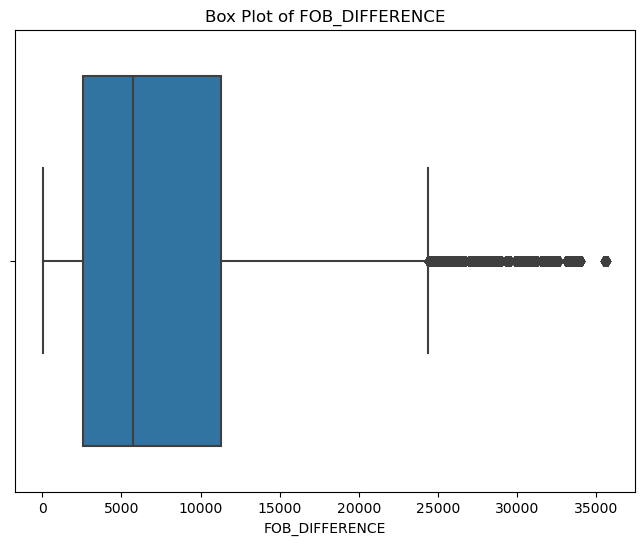

In [55]:
plt.figure(figsize=(8,6))
sns.boxplot(x=combined['FOB_DIFFERENCE'])
plt.title('Box Plot of FOB_DIFFERENCE')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FOB_DIFFERENCE', ylabel='Count'>

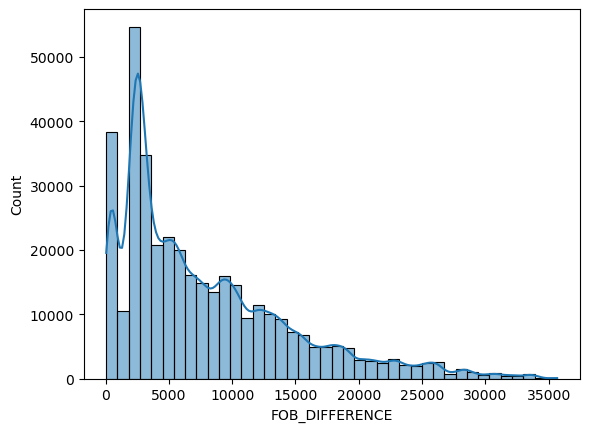

In [56]:
sns.histplot(combined["FOB_DIFFERENCE"], bins=40, kde=True)

In [57]:
combined['FOB_DIFFERENCE'].describe()

count    376554.000000
mean       7817.364922
std        6800.464569
min          54.993126
25%        2598.114746
50%        5706.589233
75%       11296.842163
max       35653.958008
Name: FOB_DIFFERENCE, dtype: float64

## Calculating Fuel Imbalance Between Left and Right Wings

In [58]:
# Total Fuel in Left and Right Wing
combined['TOTAL_FUEL_LW'] = (combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'])
combined['TOTAL_FUEL_RW'] = (combined['VALUE_FUEL_QTY_RXT'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'])

# Fuel Difference
combined['LW_RW_DIFF'] = (combined['TOTAL_FUEL_LW'] - combined['TOTAL_FUEL_RW']).abs()

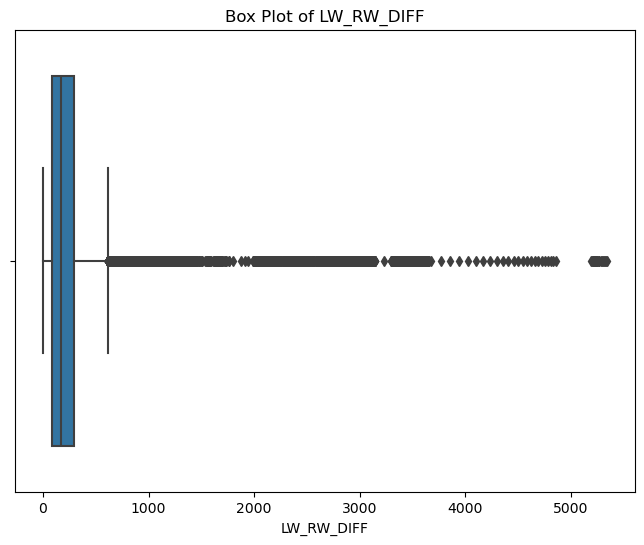

In [59]:
plt.figure(figsize=(8,6))  
sns.boxplot(x=combined['LW_RW_DIFF'])
plt.title('Box Plot of LW_RW_DIFF')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='LW_RW_DIFF', ylabel='Count'>

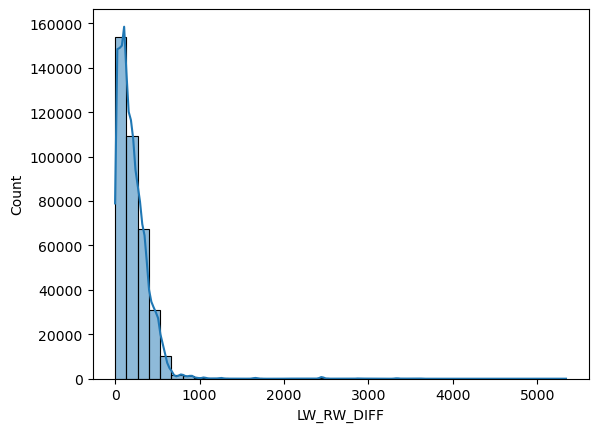

In [60]:
sns.histplot(combined["LW_RW_DIFF"], bins=40, kde=True)

In [61]:
combined['LW_RW_DIFF'].describe()

count    376554.000000
mean        213.144720
std         217.250952
min           0.000000
25%          83.000000
50%         171.000000
75%         297.000000
max        5340.000000
Name: LW_RW_DIFF, dtype: float64

## Comparision with Altitude

In [62]:
combined['ALTITUDE_DIFF'] = combined.groupby('Flight')['FW_GEO_ALTITUDE'].transform('diff')

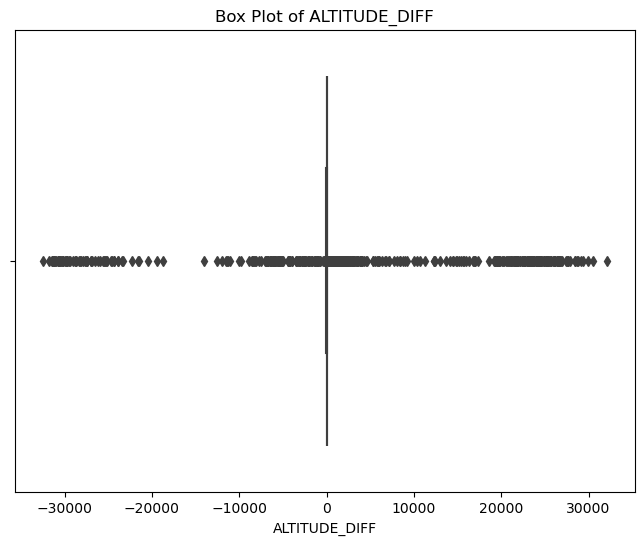

In [63]:
plt.figure(figsize=(8,6))  
sns.boxplot(x=combined['ALTITUDE_DIFF'])
plt.title('Box Plot of ALTITUDE_DIFF')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ALTITUDE_DIFF', ylabel='Count'>

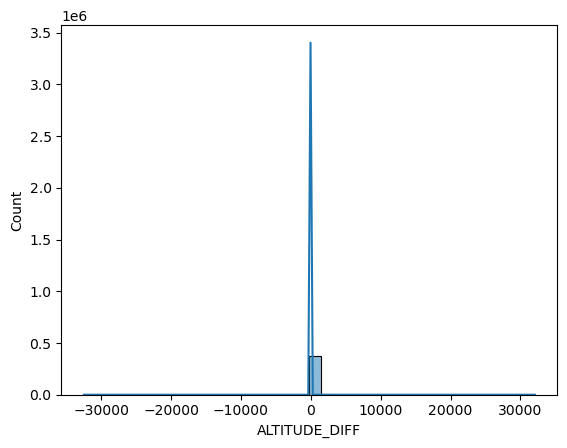

In [64]:
sns.histplot(combined["ALTITUDE_DIFF"], bins=40, kde=True)

In [65]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376554 entries, 2015-07-21 03:51:31 to 2018-04-22 11:45:45
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FUEL_USED_2         376554 non-null  float64
 1   FUEL_USED_3         376554 non-null  float64
 2   FUEL_USED_4         376554 non-null  float64
 3   FW_GEO_ALTITUDE     376554 non-null  float64
 4   VALUE_FOB           376554 non-null  float64
 5   VALUE_FUEL_QTY_CT   376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1  376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2  376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3  376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4  376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT  376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT  376554 non-null  float64
 12  FLIGHT_PHASE_COUNT  376554 non-null  float64
 13  FUEL_USED_1         376554 non-null  float64
 14  Flight              376554 non-null  float64
 15  

# EDA

### Fuel Discrepancy vs Left and Right Wing Difference

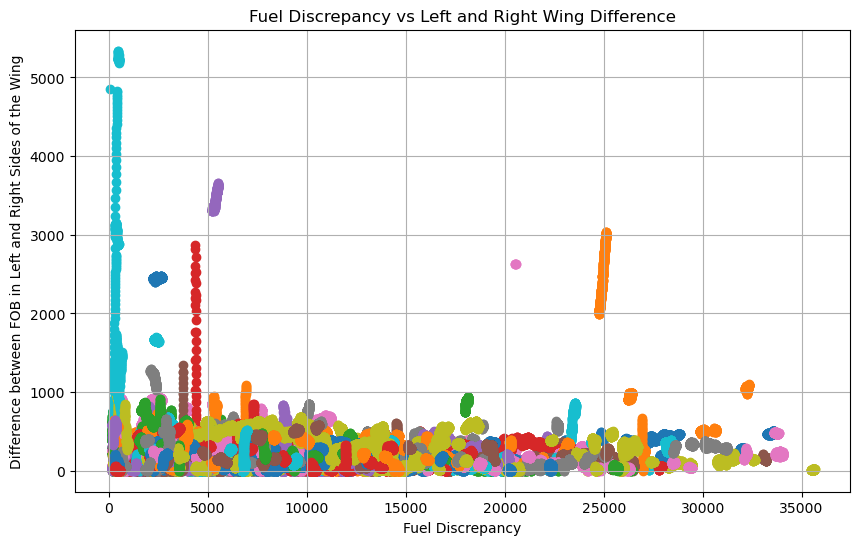

In [66]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
for flight in combined['Flight'].unique():
    flight_data = combined[combined['Flight'] == flight]
    plt.scatter(flight_data['FOB_DIFFERENCE'], flight_data['LW_RW_DIFF'], label=f'Flight {flight}')

# Set the title and axis labels
plt.title("Fuel Discrepancy vs Left and Right Wing Difference")
plt.xlabel("Fuel Discrepancy")
plt.ylabel("Difference between FOB in Left and Right Sides of the Wing")

# Show the plot
plt.grid(True)
plt.show()


In [67]:
# fig = px.scatter(combined, x="FOB_DIFFERENCE", y="LW_RW_DIFF",
#               title="Fuel Discrepancy vs Left and Right Wing Difference",
#               color="Flight")
# fig.update_layout(xaxis_title="Fuel Discrepancy", 
#                   yaxis_title="Difference between FOB in Left and Right Sides of the Wing")
# fig.show()

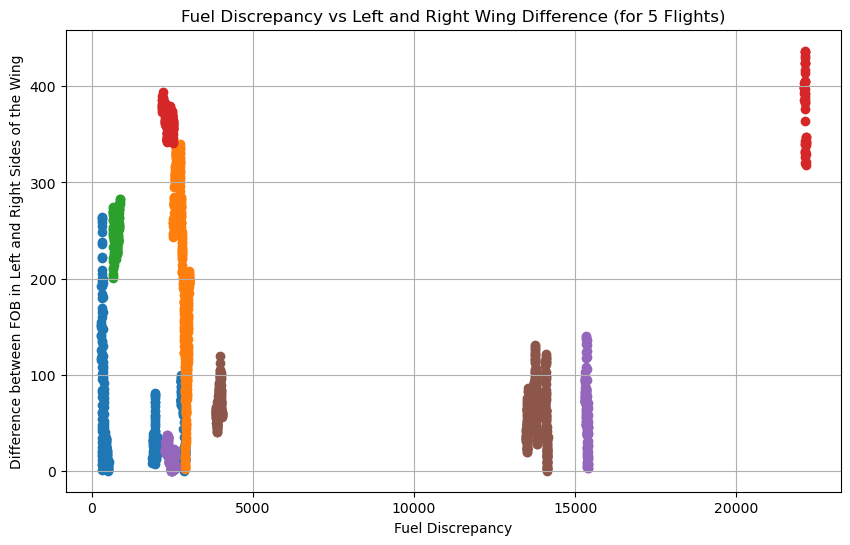

In [68]:
import matplotlib.pyplot as plt

flights_to_plot = combined['Flight'].unique()[:7]

# Create a scatter plot
plt.figure(figsize=(10, 6))
for flight in flights_to_plot[1:]:
    flight_data = combined[combined['Flight'] == flight]
    plt.scatter(flight_data['FOB_DIFFERENCE'], flight_data['LW_RW_DIFF'], label=f'Flight {flight}')

# Set the title and axis labels
plt.title("Fuel Discrepancy vs Left and Right Wing Difference (for 5 Flights)")
plt.xlabel("Fuel Discrepancy")
plt.ylabel("Difference between FOB in Left and Right Sides of the Wing")

# Show the plot
plt.grid(True)
plt.show()

### Fuel Discrepancy vs Altitude Difference

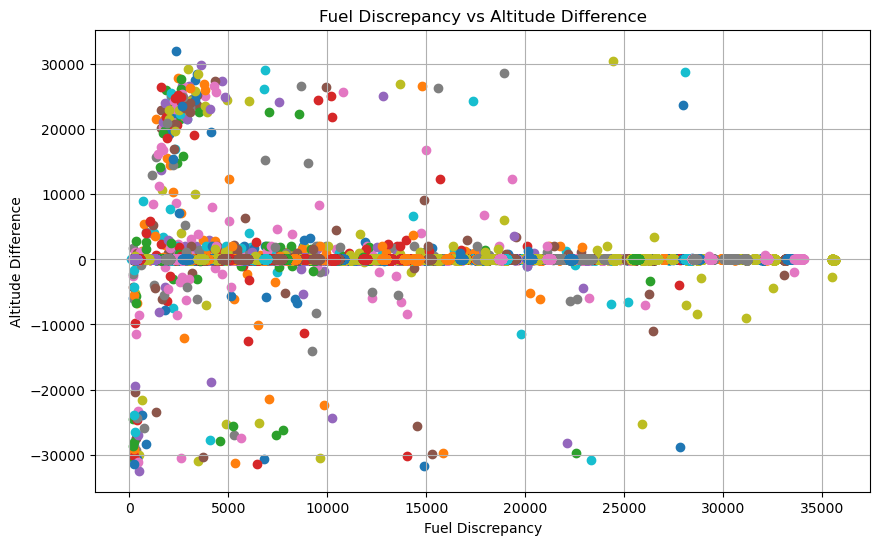

In [69]:
# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Iterate through each flight and plot the scatter plot
for flight in combined['Flight'].unique():
    flight_data = combined[combined['Flight'] == flight]
    
    # Scatter plot for each flight, with color differentiation based on the 'Flight'
    plt.scatter(flight_data['FOB_DIFFERENCE'], flight_data['ALTITUDE_DIFF'], label=f'Flight {flight}')

# Set the title and axis labels
plt.title("Fuel Discrepancy vs Altitude Difference")
plt.xlabel("Fuel Discrepancy")
plt.ylabel("Altitude Difference")

# Show the plot with a grid
plt.grid(True)
plt.show()


In [70]:
# fig = px.scatter(combined, x="FOB_DIFFERENCE", y="ALTITUDE_DIFF",
#               title="Fuel Discrepancy vs Altitude Difference",
#               color="Flight")
# fig.update_layout(xaxis_title="Fuel Discrepancy", 
#                   yaxis_title="Altitude Difference")
# fig.show()

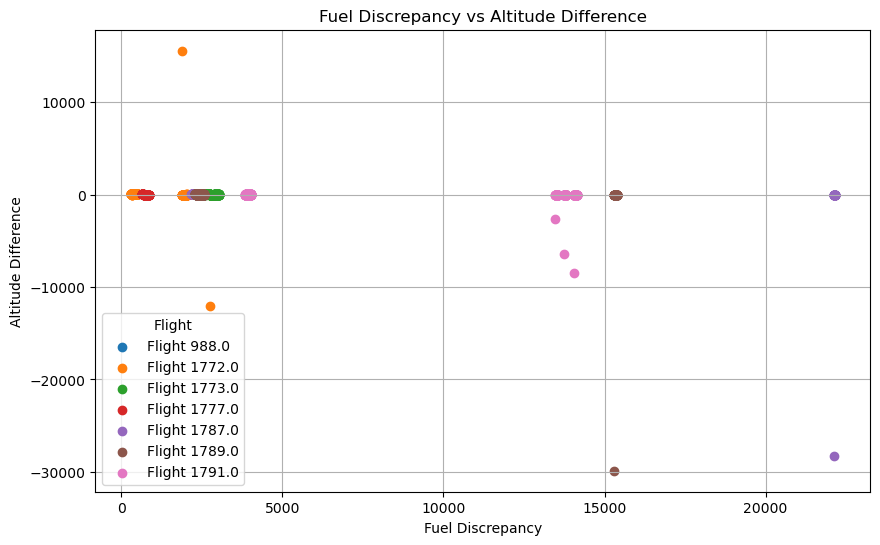

In [71]:
# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Iterate through each flight and plot the scatter plot
for flight in flights_to_plot:
    flight_data = combined[combined['Flight'] == flight]
    
    # Scatter plot for each flight, with color differentiation based on the 'Flight'
    plt.scatter(flight_data['FOB_DIFFERENCE'], flight_data['ALTITUDE_DIFF'], label=f'Flight {flight}')

# Set the title and axis labels
plt.title("Fuel Discrepancy vs Altitude Difference")
plt.xlabel("Fuel Discrepancy")
plt.ylabel("Altitude Difference")

# Add a legend for flight differentiation
plt.legend(title="Flight")

# Show the plot with a grid
plt.grid(True)
plt.show()

### Left Wing Right Wing Difference vs Altitude Difference

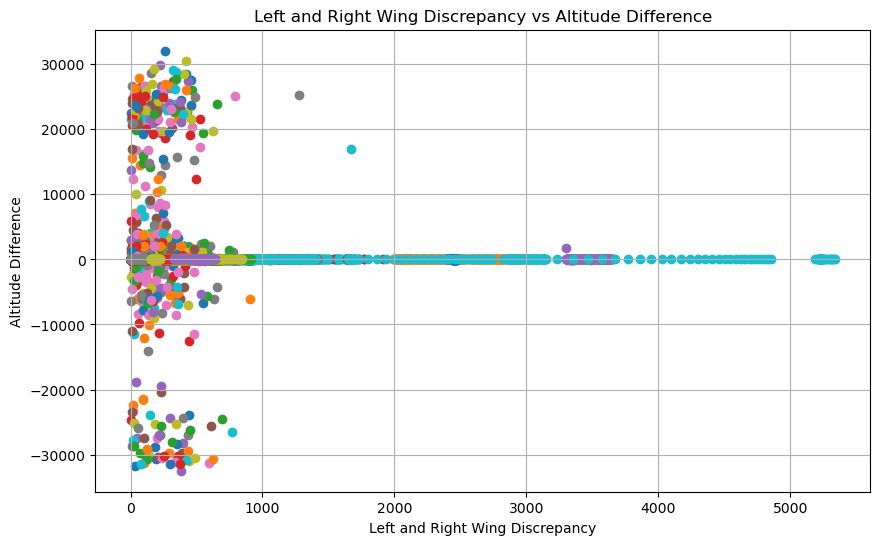

In [72]:
import matplotlib.pyplot as plt

# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Iterate through each flight and plot the scatter plot
for flight in combined['Flight'].unique():
    flight_data = combined[combined['Flight'] == flight]
    
    # Scatter plot for each flight, with color differentiation based on the 'Flight'
    plt.scatter(flight_data['LW_RW_DIFF'], flight_data['ALTITUDE_DIFF'], label=f'Flight {flight}')

# Set the title and axis labels
plt.title("Left and Right Wing Discrepancy vs Altitude Difference")
plt.xlabel("Left and Right Wing Discrepancy")
plt.ylabel("Altitude Difference")

# Show the plot with a grid
plt.grid(True)
plt.show()

In [73]:
# fig = px.scatter(combined, x="LW_RW_DIFF", y="ALTITUDE_DIFF",
#               title="Left and Right Wing Discrepancy vs Altitude Difference",
#               color="Flight")
# fig.update_layout(xaxis_title="Left and Right Wing Discrepancy", 
#                   yaxis_title="Altitude Difference")
# fig.show()

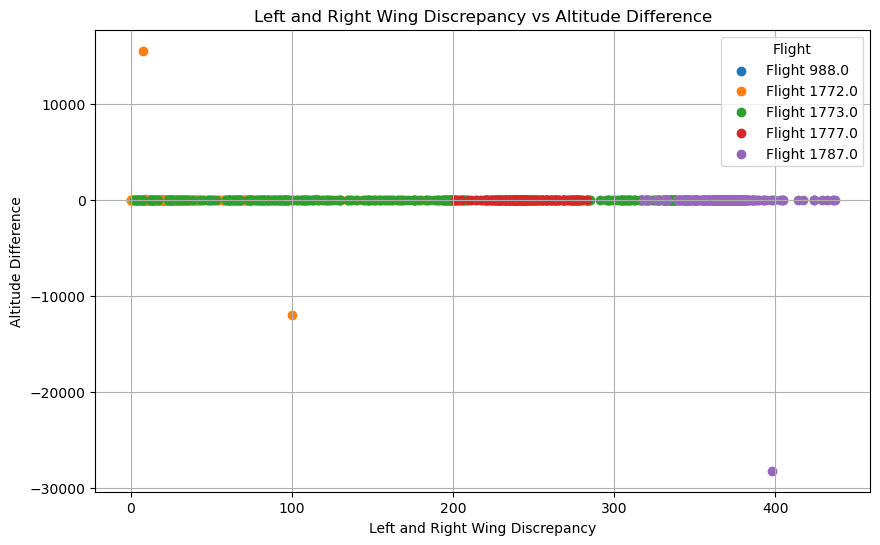

In [74]:
# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Limit the loop to only the first 5 flights
for flight in combined['Flight'].unique()[:5]:  # Limit to the first 5 flights
    flight_data = combined[combined['Flight'] == flight]
    
    # Scatter plot for each flight, with color differentiation based on the 'Flight'
    plt.scatter(flight_data['LW_RW_DIFF'], flight_data['ALTITUDE_DIFF'], label=f'Flight {flight}')

# Set the title and axis labels
plt.title("Left and Right Wing Discrepancy vs Altitude Difference")
plt.xlabel("Left and Right Wing Discrepancy")
plt.ylabel("Altitude Difference")

# Add a legend for flight differentiation
plt.legend(title="Flight")

# Show the plot with a grid
plt.grid(True)
plt.show()


### VALUE_FOB with EXPECTED_FOB
To see the discrepancies in value of fuel on board `VALUE_FOB` and the expected fuel on board `EXPECTED_FOB`

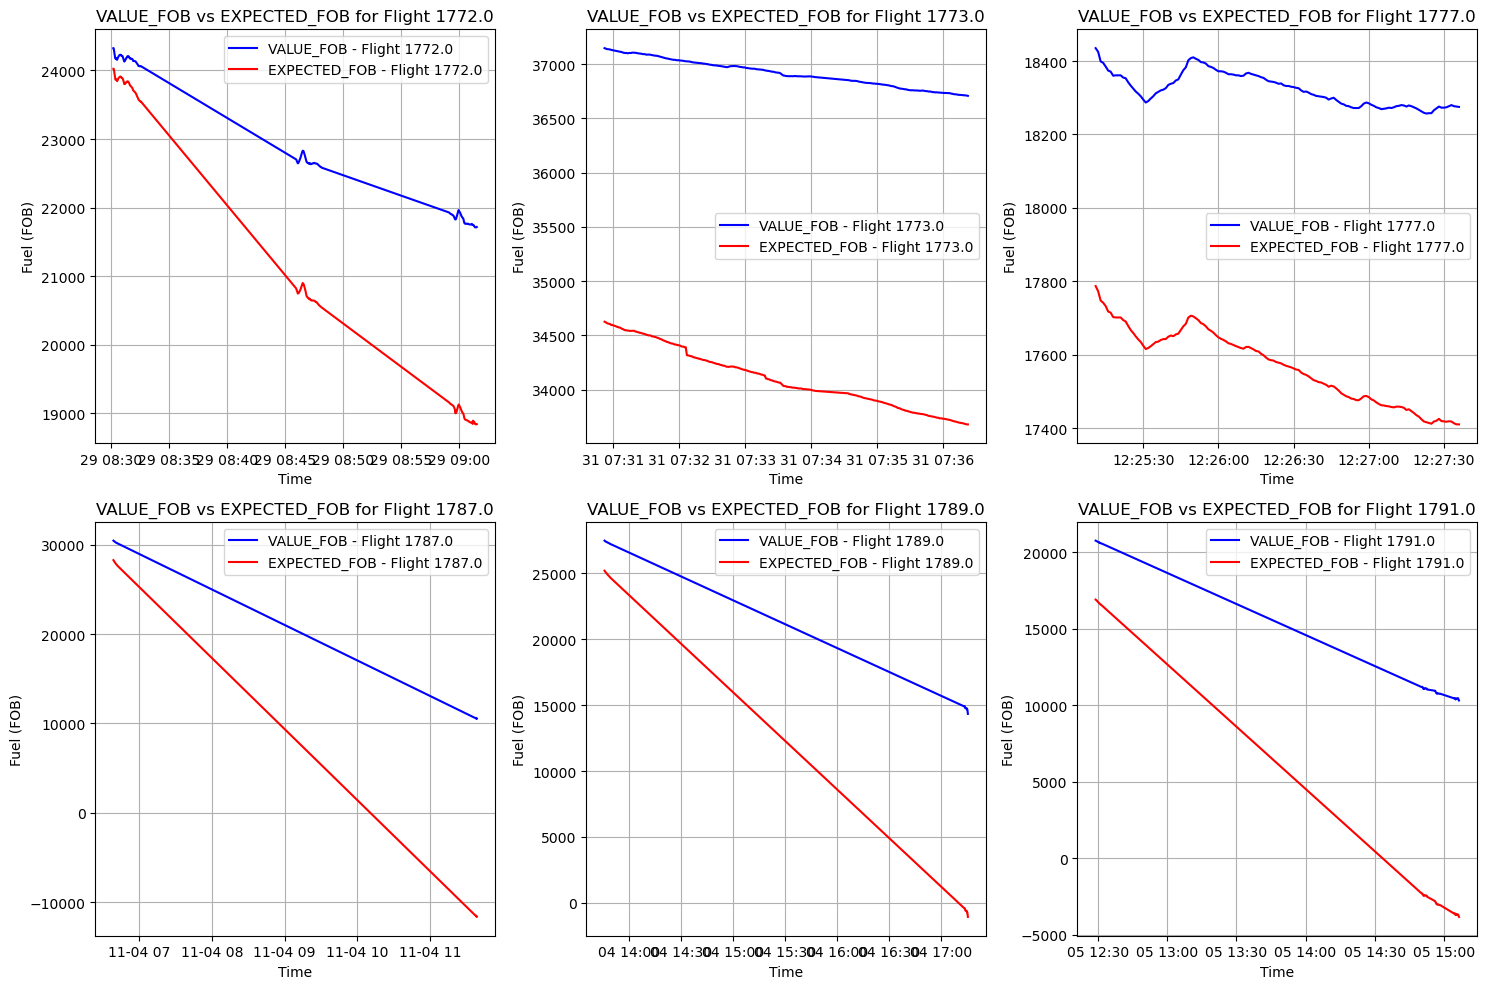

In [75]:
import matplotlib.pyplot as plt

# Get unique flights (limit to 5 flights for better visualization)
unique_flights = combined['Flight'].unique()[:7]

# Initialize counter
counter = 0

# Set up the number of rows and columns for subplots
rows = 2  # you can change this based on the number of flights
cols = 3  # you can change this based on the number of flights

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (if it's 2D)
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(unique_flights[1:]):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['Flight'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Plot the actual fuel on board (VALUE_FOB) vs expected fuel on board (EXPECTED_FOB)
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FOB - Flight {flight}', color='blue')
    ax.plot(flight_data.index, flight_data['EXPECTED_FOB'], label=f'EXPECTED_FOB - Flight {flight}', color='red')
    
    # Set the title and labels for the subplot
    ax.set_title(f'VALUE_FOB vs EXPECTED_FOB for Flight {flight}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Fuel (FOB)')
    
    # Add legend
    ax.legend()
    
    # Show grid
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Comparing Starting FOB with TOTAL_FUEL_USED and the remaining fuel on board (VALUE_FOB)
By comparing `START_FOB` (the fuel initially onboard) with `TOTAL_FUEL_USED` + `VALUE_FOB` (the amount of fuel that should be left onboard after accounting for fuel use), you can identify significant differences. If the fuel used plus the expected fuel on board is consistently higher than the starting fuel, this may indicate a fuel leak.

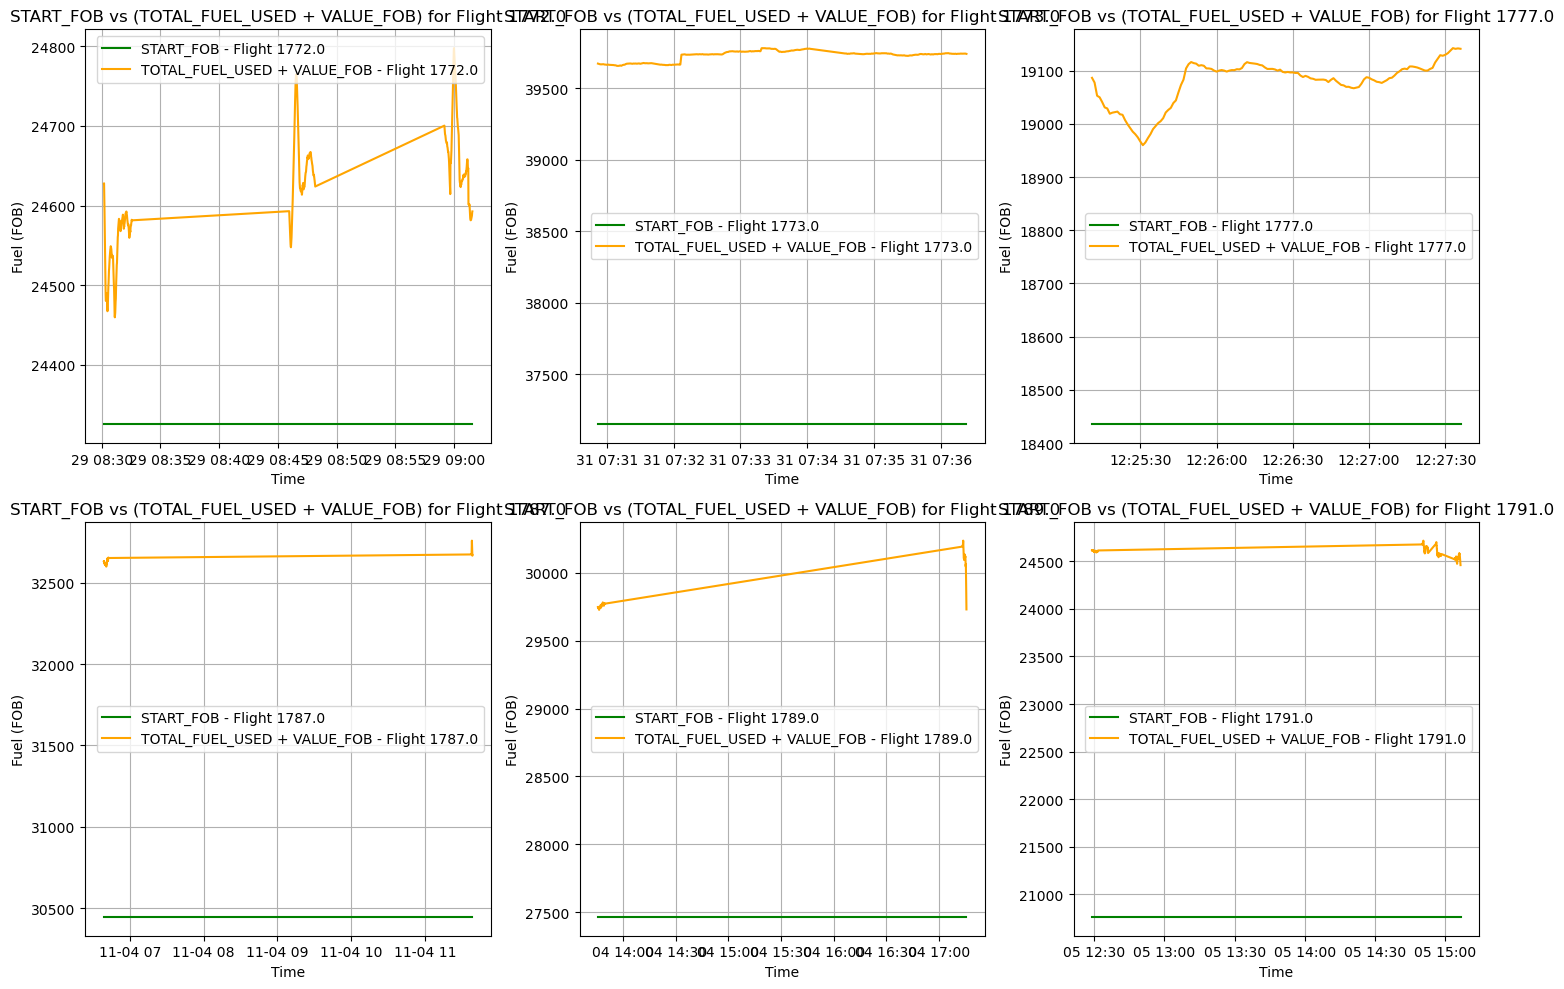

In [76]:
# Initialize counter
counter = 0

# Set up the number of rows and columns for subplots
rows = 2 
cols = 3  

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (if it's 2D)
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(unique_flights[1:]):  # Skipping the first flight for the plot
    if counter == 7:
        break

    # Filter data for that flight
    flight_data = combined[combined['Flight'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Plot the START_FOB
    ax.plot(flight_data.index, flight_data['START_FOB'], label=f'START_FOB - Flight {flight}', color='green')
    
    # Calculate TOTAL_FUEL_USED + VALUE_FOB for the entire flight
    total_fuel_used_plus_fob = flight_data['TOTAL_FUEL_USED'] + flight_data['VALUE_FOB']
    
    # Plot the TOTAL_FUEL_USED + VALUE_FOB
    ax.plot(flight_data.index, total_fuel_used_plus_fob, label=f'TOTAL_FUEL_USED + VALUE_FOB - Flight {flight}', color='orange')
    
    # Set the title and labels for the subplot
    ax.set_title(f'START_FOB vs (TOTAL_FUEL_USED + VALUE_FOB) for Flight {flight}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Fuel (FOB)')
    
    # Add legend
    ax.legend()
    
    # Show grid
    ax.grid(True)

    # Increment counter
    counter += 1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Left and Right Wing Differences vs Altitude
- **Asymmetry in Fuel Consumption:** A significant and consistent difference between the left and right wings' fuel levels could indicate a fuel leak in one of the wings. Normally, fuel usage should be fairly balanced across both wings, so irregularities may suggest a problem.

- **Altitude Impact:** If the fuel difference becomes more pronounced at certain altitudes, it might signal that a fuel leak or imbalance in fuel transfer is worsening under specific flight conditions, such as changes in air pressure or flight dynamics at higher altitudes.

- **Early Detection:** By monitoring this difference in real-time, you can identify potential fuel leaks early in the flight, allowing corrective action to be taken before it becomes a safety issue.

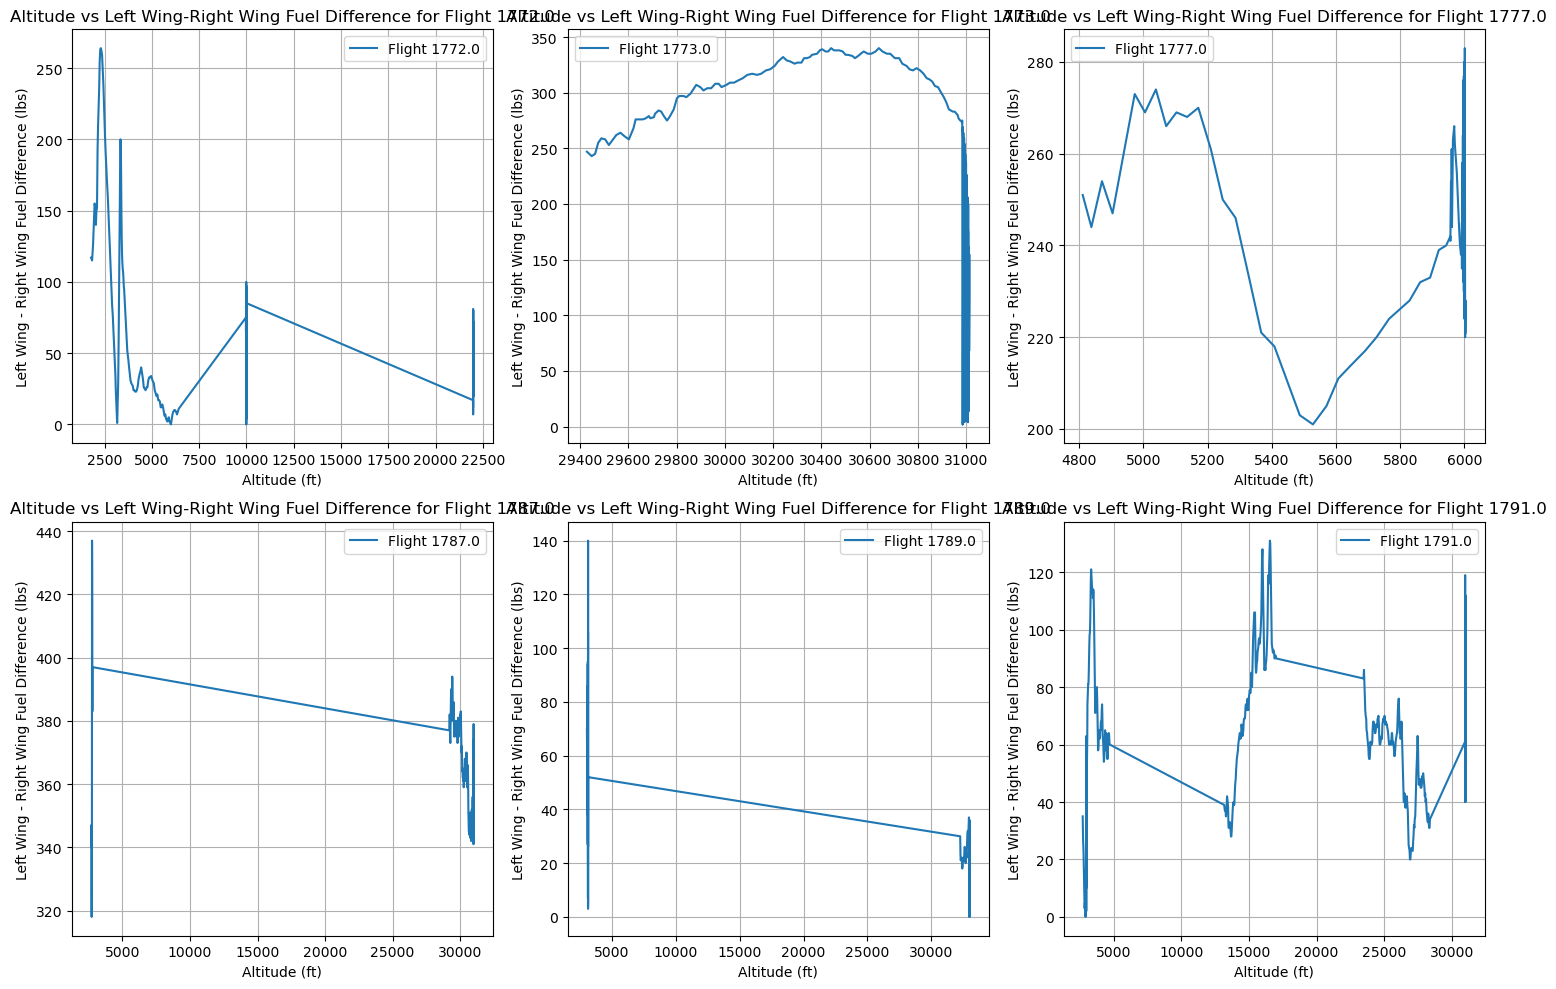

In [77]:
# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (if it's 2D)
axes = axes.flatten()

# For each unique flight
counter = 0
for idx, flight in enumerate(unique_flights[1:]):  # Skipping the first flight for the plot
    if counter == 7:
        break

    # Filter data for that flight
    flight_data = combined[combined['Flight'] == flight]
    
    # Sort the data by 'FW_GEO_ALTITUDE' for a meaningful line graph
    flight_data = flight_data.sort_values(by='FW_GEO_ALTITUDE')
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Line plot of Altitude vs Left Wing-Right Wing fuel difference
    ax.plot(flight_data['FW_GEO_ALTITUDE'], flight_data['LW_RW_DIFF'], label=f'Flight {flight}')
    
    # Set the title and labels for the subplot
    ax.set_title(f'Altitude vs Left Wing-Right Wing Fuel Difference for Flight {flight}')
    ax.set_xlabel('Altitude (ft)')
    ax.set_ylabel('Left Wing - Right Wing Fuel Difference (lbs)')
    
    # Add a legend
    ax.legend()
    
    # Show grid
    ax.grid(True)

    # Increment counter
    counter += 1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


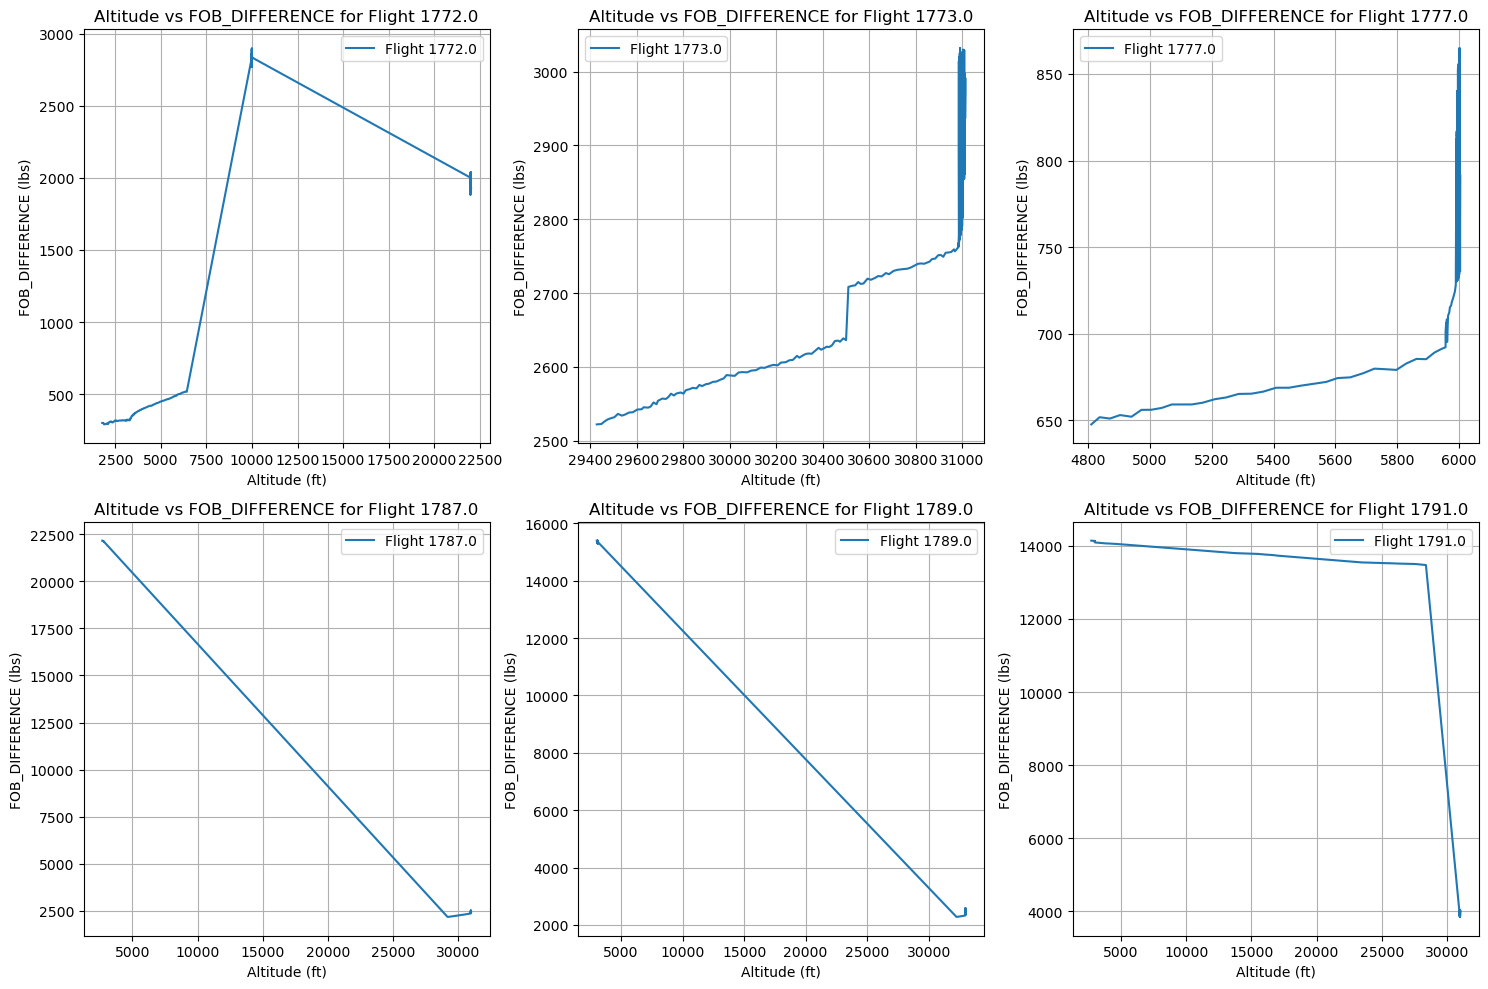

In [78]:
# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (if it's 2D)
axes = axes.flatten()

# For each unique flight
counter = 0
for idx, flight in enumerate(unique_flights[1:]):  # Skipping the first flight for the plot
    if counter == 7:
        break

    # Filter data for that flight
    flight_data = combined[combined['Flight'] == flight]
    
    # Sort the data by 'FW_GEO_ALTITUDE' for a meaningful line graph
    flight_data = flight_data.sort_values(by='FW_GEO_ALTITUDE')
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Line plot of Altitude vs FOB_DIFFERENCE
    ax.plot(flight_data['FW_GEO_ALTITUDE'], flight_data['FOB_DIFFERENCE'], label=f'Flight {flight}')
    
    # Set the title and labels for the subplot
    ax.set_title(f'Altitude vs FOB_DIFFERENCE for Flight {flight}')
    ax.set_xlabel('Altitude (ft)')
    ax.set_ylabel('FOB_DIFFERENCE (lbs)')
    
    # Add a legend
    ax.legend()
    
    # Show grid
    ax.grid(True)

    # Increment counter
    counter += 1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


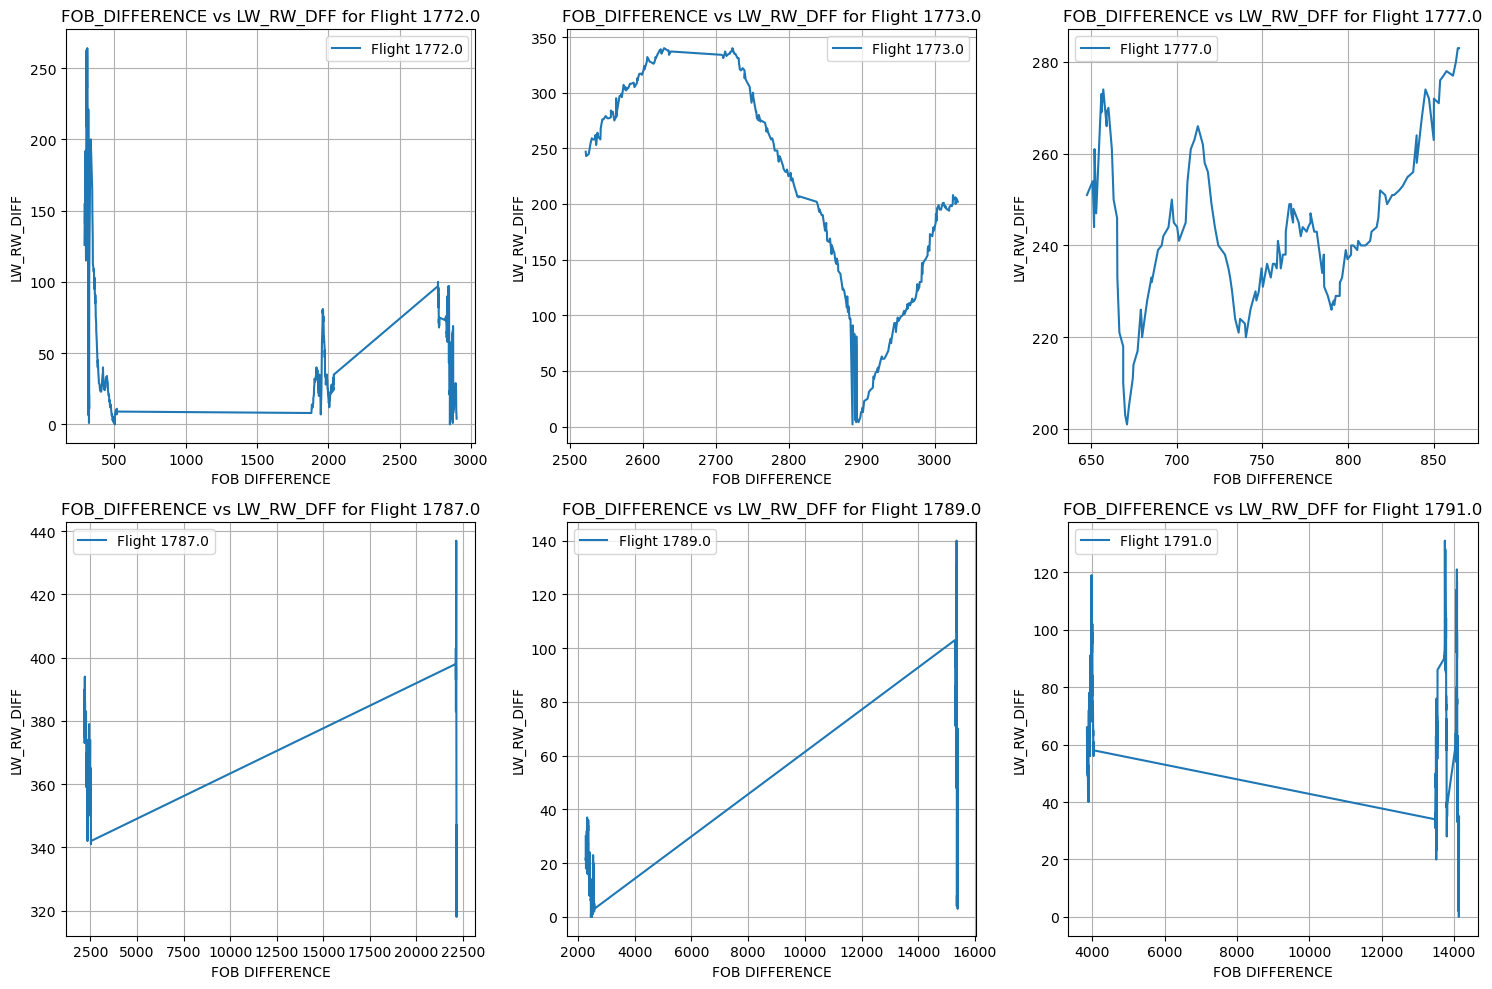

In [79]:
# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (if it's 2D)
axes = axes.flatten()

# For each unique flight
counter = 0
for idx, flight in enumerate(unique_flights[1:]):  # Skipping the first flight for the plot
    if counter == 7:
        break

    # Filter data for that flight
    flight_data = combined[combined['Flight'] == flight]
    
    # Sort the data by 'FW_GEO_ALTITUDE' for a meaningful line graph
    flight_data = flight_data.sort_values(by='FOB_DIFFERENCE')
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Line plot of Altitude vs FOB_DIFFERENCE
    ax.plot(flight_data['FOB_DIFFERENCE'], flight_data['LW_RW_DIFF'], label=f'Flight {flight}')
    
    # Set the title and labels for the subplot
    ax.set_title(f'FOB_DIFFERENCE vs LW_RW_DFF for Flight {flight}')
    ax.set_xlabel('FOB DIFFERENCE')
    ax.set_ylabel('LW_RW_DIFF')
    
    # Add a legend
    ax.legend()
    
    # Show grid
    ax.grid(True)

    # Increment counter
    counter += 1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
